# Computer Vision Lab

### Load MNIST (modified NIST dataset)

http://yann.lecun.com/exdb/mnist/

*"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image."*


@misc{TFDS,
  title = { {TensorFlow Datasets}, A collection of ready-to-use datasets},
  howpublished = {\url{https://www.tensorflow.org/datasets}},
}


> Following example by https://gist.github.com/datlife/abfe263803691a8864b7a2d4f87c4ab8

In [1]:
### Import packages and functions
import tensorflow as tf   # only work from tensorflow==1.9.0-rc1 and after
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv3D, MaxPool3D
print(tf.__version__)

2.1.0


In [2]:
def tfdata_generator(images, labels, is_training, batch_size=128):
    '''Construct a data generator using tf.Dataset'''

    def preprocess_fn(image, label):
        '''A transformation function to preprocess raw data
        into trainable input. '''
        
        
        x = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
        
        ## The input shape for the convolutional neural network is 32 by definition of the LeNet,
        ## to ensure that the figure is centered in the middle of the frame. (LeCun et. al 1998)
        ## To solve this issues we use a standar procedure called padding
        
        paddings = tf.constant([[2, 2,], [2, 2,], [0,0,]])
        x = tf.pad(x, paddings)
        
        y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(1000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = tf.data.Dataset.map(dataset,
        preprocess_fn,
        num_parallel_calls=4  # cpu cores
        )
    
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# LeNet 5 
Le Cunn et. al 1998


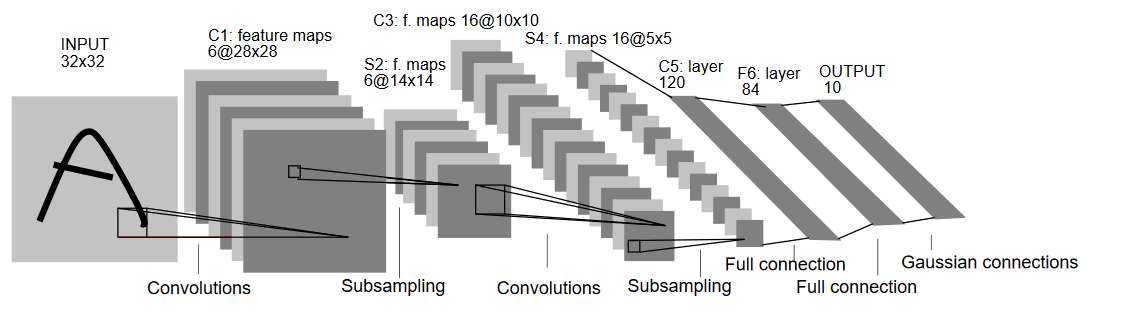

This image is Figure 2 in Le Cunn et al. 1998 (PROC. of the IEEE) Gradient-Based Learning Applied to Document Recognition

The development of the example has been inspired by the original paper (Le Cunn et al. 1998) and the medium article:

### LeNet-5 in 9 lines of code using Keras Keras is a high-level open source APIs, written in Python and capable of running on top of TensorFlow, Microsoft’s CNTK, or Theano
> https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

Mostafa Gazar (Nov 26, 2018)

In [3]:
def keras_model():

    inputs = Input(shape=(32, 32, 1))
    x = Conv2D(filters = 6, kernel_size=(5, 5),
               activation='relu', padding='valid')(inputs)
    
    ## For the subsampling, LeCunn used to add the values and multiply by a training parameter,
    ## using the Avg Pool is like adding and multiplying per 1/N
    
    x = AvgPool2D(pool_size=(2, 2))(x)
    x = Conv2D(filters = 16, kernel_size=(5, 5), activation='relu')(x)
    
    x = AvgPool2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters = 120, kernel_size=(5, 5), activation='relu')(x)
    x = Flatten()(x)
#     x = Dense(120, activation='relu')(x)
    x = Dense(84, activation='tanh')(x)
    
    outputs = Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [4]:
# parameter definition
_EPOCHS      = 20
_NUM_CLASSES = 10
_BATCH_SIZE  = 128

In [5]:
# #############
# Load Dataset
# #############
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
training_set = tfdata_generator(x_train, y_train, is_training=True, batch_size=_BATCH_SIZE)
testing_set  = tfdata_generator(x_test, y_test, is_training=False, batch_size=_BATCH_SIZE)

# #############
# Train Model
# #############
model = keras_model()  # your keras model here
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

model.fit(
  training_set.batch(_BATCH_SIZE),
  steps_per_epoch=len(x_train) // _BATCH_SIZE,
  epochs=_EPOCHS,
  validation_data=testing_set.batch(_BATCH_SIZE),
  validation_steps=len(x_test) // _BATCH_SIZE,
  verbose = 1)
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0     

Using TensorFlow backend.


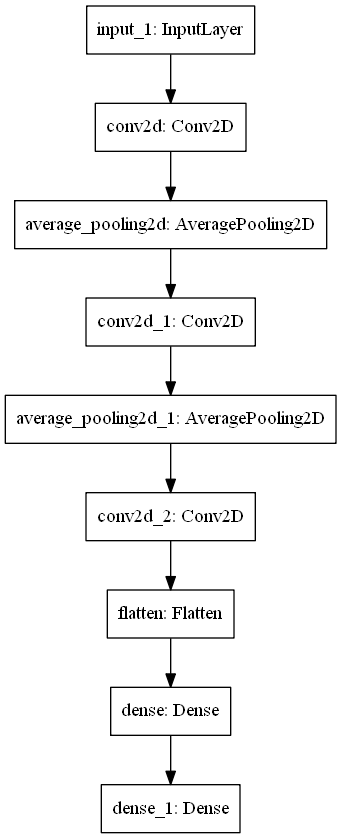

In [6]:
from keras.utils import plot_model
plot_model(model)

In [7]:
import matplotlib.pyplot as plt

History = model.history
# Plot training & validation accuracy values
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open("lenet5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lenet5.h5")
print("Saved model to disk")
 
# later...
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('lenet5.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("lenet5.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Saved model to disk
Loaded model from disk
78/78 [==============================] - 1s 19ms/step - loss: 0.0514 - acc: 0.9867
Test loss: 0.05136363908408944
Test accuracy: 0.98667866


# AlexNet
Alex Krizhevsky et. al 2012


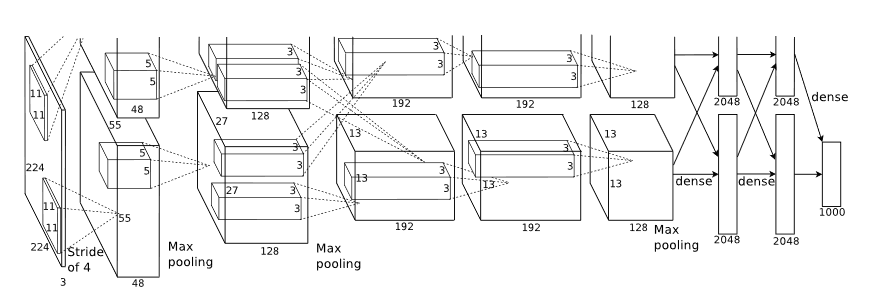

This image is Figure 2 in Alex Krizhevsky et. al 2012(NIPS Proceedings) ImageNet Classification with Deep ConvolutionalNeural Networks

In [9]:
def tfdata_generator(images, labels, is_training, batch_size=128):
    '''Construct a data generator using tf.Dataset'''

    def preprocess_fn(image, label):
        '''A transformation function to preprocess raw data
        into trainable input. '''
        
        
        x = tf.reshape(tf.cast(image, tf.float32), (28, 28, 1))
        
        ## The input shape for the convolutional neural network is 32 by definition of the LeNet,
        ## to ensure that the figure is centered in the middle of the frame. (LeCun et. al 1998)
        ## To solve this issues we use a standar procedure called padding
        
        paddings = tf.constant([[98, 98,], [98, 98,], [0,0,]])
        x = tf.pad(x, paddings)
        x = tf.image.grayscale_to_rgb(x)

        
        y = tf.one_hot(tf.cast(label, tf.uint8), _NUM_CLASSES)
        return x, y

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_training:
        dataset = dataset.shuffle(1000)  # depends on sample size

    # Transform and batch data at the same time
    dataset = tf.data.Dataset.map(dataset,
        preprocess_fn,
        num_parallel_calls=4  # cpu cores
        )
    
    dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [10]:
def keras_model():

    inputs = Input(shape=(224, 224, 3))
    
    # 1st Convolutional Layer
    x = Conv2D(filters=96, activation='relu', kernel_size=(11,11),
           strides=(4,4), padding='valid')(inputs)

    # Pooling 
    ## The author decides to use an overlapping pool 
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)

    # 2nd Convolutional Layer
    x = Conv2D(filters=256, kernel_size=(5,5), 
               activation = 'relu', padding='valid')(x)
    
    # Pooling
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # 3rd Convolutional Layer
    x = Conv2D(filters=384, kernel_size=(3,3), 
               activation='relu', padding='valid')(x)
    
    # 4th Convolutional Layer
    x = Conv2D(filters=384, kernel_size=(3,3), 
               activation = 'relu', padding='valid')(x)
    
    # 5th Convolutional Layer
    x = Conv2D(filters=256, kernel_size=(3,3),  activation = 'relu', padding='valid')(x)
    # Pooling
    x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # Passing it to a dense layer
    x = Flatten()(x)
    # 1st Dense Layer
    x = Dense(4096, activation='relu')(x)
    
    # Add Dropout to prevent overfitting
    x = Dropout(0.5)(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # 2nd Dense Layer
    x = Dense(4096, activation = 'relu')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # 3rd Dense Layer
    x = Dense(1000, activation = 'relu')(x)
    # Batch Normalisation
    x = BatchNormalization()(x)

    # Output Layer
    outputs = Dense(10, activation = 'softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [11]:
# parameter definition
_EPOCHS      = 5
_NUM_CLASSES = 10
_BATCH_SIZE  = 128

In [12]:
# #############
# Load Dataset
# #############
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
training_set = tfdata_generator(x_train, y_train, is_training=True, batch_size=_BATCH_SIZE)
testing_set  = tfdata_generator(x_test, y_test, is_training=False, batch_size=_BATCH_SIZE)

# #############
# Train Model
# #############
model = keras_model()  # your keras model here
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

model.fit(
  training_set.batch(_BATCH_SIZE),
  steps_per_epoch=len(x_train) // _BATCH_SIZE,
  epochs=_EPOCHS,
  validation_data=testing_set.batch(_BATCH_SIZE),
  validation_steps=len(x_test) // _BATCH_SIZE,
  verbose = 1)
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1024

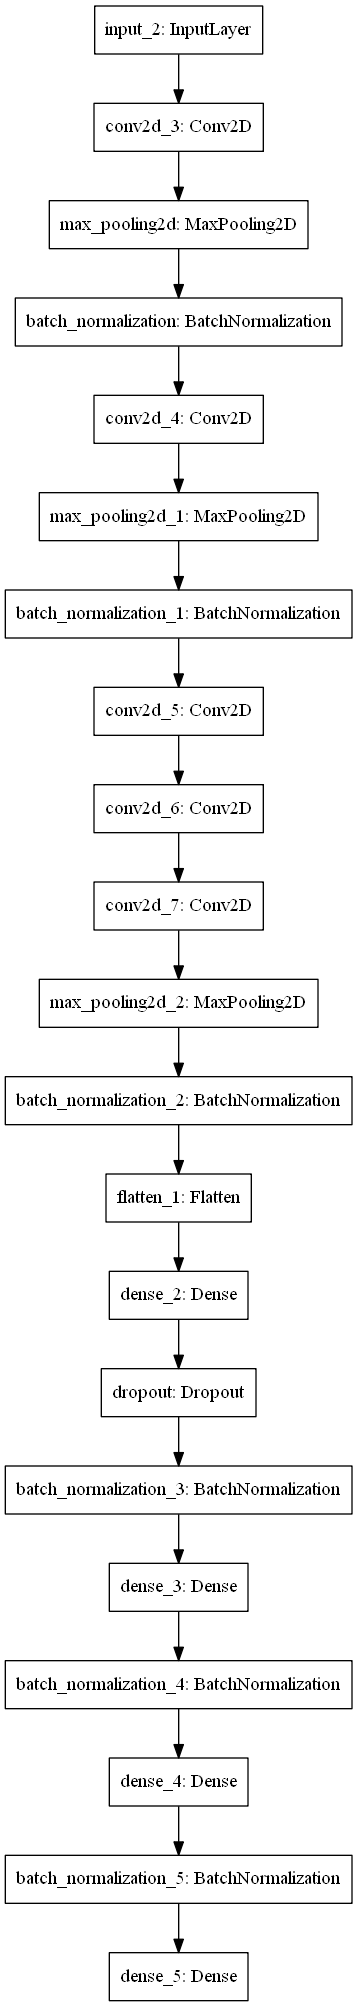

In [13]:
from keras.utils import plot_model
plot_model(model)

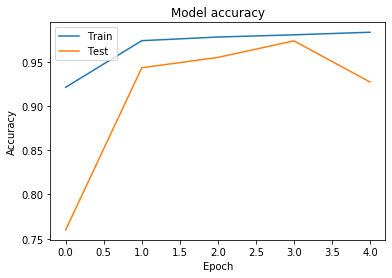

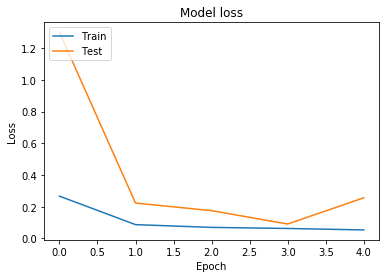

In [14]:
import matplotlib.pyplot as plt

History = model.history
# Plot training & validation accuracy values
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Save the model since it takes 5h to train

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("alexnet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("alexnet.h5")
print("Saved model to disk")
 

Saved model to disk


In [16]:
# later...
 
# load json and create model
json_file = open('alexnet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("alexnet.h5")
print("Loaded model from disk")


Loaded model from disk


In [17]:
score = model.evaluate(testing_set.batch(_BATCH_SIZE),
                       steps=len(x_test) // _BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

78/78 [==============================] - 124s 2s/step - loss: 0.2560 - acc: 0.9273
Test loss: 0.25604083033230823
Test accuracy: 0.92728364
